## Оптимизация маркетинговых затрат Яндекс.Афиши

В исследовании проанализированы данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

    1.Лог сервера с данными о посещениях сайта Яндекс.Афиши: /datasets/visits_log.csv
    2.Выгрузка всех заказов за этот период: /datasets/orders_log.csv
    3.Статистика рекламных расходов: /datasets/costs.csv
    
Результатом исследования является рекомендации для маркетологов, куда и сколько стоит вкладывать денег.

## Содержание исследования
_____

#### Подготовка:
* <a href="#step_1">1. Изучение файлов с данными, получение общей информации, загрузка библиотек.</a>
* <a href="#step_2">2. Предобработка данных.</a>

#### Анализ данных:
* <a href="#step_3">3. Продукт.</a>
* * <a href="#step_31">3.1 Сколько людей пользуются в день, неделю, месяц?</a>
* * <a href="#step_32">3.2 Сколько сессий в день?</a>
* * <a href="#step_33">3.3 Сколько длится одна сессия?</a>
* * <a href="#step_34">3.4 Как часто люди возвращаются?</a>
<br>
<br>
* <a href="#step_4">4. Продажи.</a>
* * <a href="#step_41">4.1 Когда люди начинают покупать?</a>
* * <a href="#step_42">4.2 Сколько раз покупают за период?</a>
* * <a href="#step_43">4.3 Какой средний чек?</a>
* * <a href="#step_43">4.4 Сколько денег приносят? (LTV)</a>
<br>
<br>
* <a href="#step_5">5. Маркетинг.</a>
* * <a href="#step_51">5.1 Сколько денег потратили?</a>
* * <a href="#step_52">5.2 Сколько стоило привлечение одного покупателя из каждого источника?</a>
* * <a href="#step_53">5.3 На сколько окупились расходы? (ROI)</a>

#### Итог:
* <a href="#step_6">6. Общий вывод</a>


<a id='step_1'></a>
### 1. Изучение файлов с данными, получение общей информации, загрузка библиотек:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Глобально снял ограничение на кол-во выводов для каждой ячейки ввода кода.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Включил возможность форматировать стили текста с помощью метода printmd()
from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))
    
# Снял ограничение на вывод кол-ва столбцов и ширины колонки.
pd.set_option('display.max_columns', None)
try:
    pd.set_option('display.max_colwidth', None)
except:
    pd.set_option('display.max_colwidth', -1)
    
# Добавил функцию вывода таблиц в одну строку, для экономии пространства и улучшения восприятия информации.
def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# Сформировал датафреймы из csv файлов сразу отсеяв дубликапты.
visits_log = pd.read_csv('/datasets/visits_log.csv').drop_duplicates().reset_index(drop = True)
orders_log = pd.read_csv('/datasets/orders_log.csv').drop_duplicates().reset_index(drop = True)
costs = pd.read_csv('/datasets/costs.csv').drop_duplicates().reset_index(drop = True)

display_side_by_side(
    [visits_log.head(5),orders_log.head(5),costs.head(5)], 
    ['Посещения', 'Заказы', 'Рекламные расходы']
)

In [4]:
printmd('**Информация о посещениях сайта, visits_log:**')
visits_log.info()
print()
print()
printmd('**Информация о заказах, orders_log:**')
orders_log.info()
print()
print()
printmd('**Информация о рекламных расходах, costs:**')
costs.info()

**Информация о посещениях сайта, visits_log:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB




**Информация о заказах, orders_log:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB




**Информация о рекламных расходах, costs:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [5]:
# Вывел уникальные значения столбцов, для проверки корректности данных. 
# Применил try except для обхода ошибок сортировки. Сортировал значения там, где это возможно.
def check_unique(df):
    a = []
    for column in df.columns:
        datatype = df[column].dtypes
        print('{} ({}):'.format(column,datatype))
        try:
            a = df[column].unique()
            a.sort()
            with np.set_printoptions(formatter={'float_kind':'{:.2f}'.format}):
                print(a)
        except:
            print(a)

        print('Кол-во элементов: {} из {}'.format(df[column].count(),len(df)))
        print()
        
printmd('**visits_log:**')
check_unique(visits_log)
print()
print()
printmd('**orders_log:**')
check_unique(orders_log)
print()
print()
printmd('**costs:**')
check_unique(costs)

**visits_log:**

Device (object):
['desktop' 'touch']
Кол-во элементов: 359400 из 359400

End Ts (object):
['2017-06-01 00:02:00' '2017-06-01 00:04:00' '2017-06-01 00:11:00' ...
 '2018-06-01 00:13:00' '2018-06-01 00:25:00' '2018-06-01 01:26:00']
Кол-во элементов: 359400 из 359400

Source Id (int64):
[ 1  2  3  4  5  6  7  9 10]
Кол-во элементов: 359400 из 359400

Start Ts (object):
['2017-06-01 00:01:00' '2017-06-01 00:02:00' '2017-06-01 00:04:00' ...
 '2018-05-31 23:57:00' '2018-05-31 23:58:00' '2018-05-31 23:59:00']
Кол-во элементов: 359400 из 359400

Uid (uint64):
[      11863502262781       49537067089222      297729379853735 ...
 18446556406699109058 18446621818809592527 18446676030785672386]
Кол-во элементов: 359400 из 359400





**orders_log:**

Buy Ts (object):
['2017-06-01 00:10:00' '2017-06-01 00:25:00' '2017-06-01 00:27:00' ...
 '2018-05-31 23:54:00' '2018-05-31 23:56:00' '2018-06-01 00:02:00']
Кол-во элементов: 50415 из 50415

Revenue (float64):
[0.00 0.01 0.02 ... 1221.37 1236.28 2633.28]
Кол-во элементов: 50415 из 50415

Uid (uint64):
[     313578113262317     1575281904278712     2429014661409475 ...
 18445601152732270159 18446156210226471712 18446167067214817906]
Кол-во элементов: 50415 из 50415





**costs:**

source_id (int64):
[ 1  2  3  4  5  9 10]
Кол-во элементов: 2542 из 2542

dt (object):
['2017-06-01' '2017-06-02' '2017-06-03' '2017-06-04' '2017-06-05'
 '2017-06-06' '2017-06-07' '2017-06-08' '2017-06-09' '2017-06-10'
 '2017-06-11' '2017-06-12' '2017-06-13' '2017-06-14' '2017-06-15'
 '2017-06-16' '2017-06-17' '2017-06-18' '2017-06-19' '2017-06-20'
 '2017-06-21' '2017-06-22' '2017-06-23' '2017-06-24' '2017-06-25'
 '2017-06-26' '2017-06-27' '2017-06-28' '2017-06-29' '2017-06-30'
 '2017-07-01' '2017-07-02' '2017-07-03' '2017-07-04' '2017-07-05'
 '2017-07-06' '2017-07-07' '2017-07-08' '2017-07-09' '2017-07-10'
 '2017-07-11' '2017-07-12' '2017-07-13' '2017-07-14' '2017-07-15'
 '2017-07-16' '2017-07-17' '2017-07-18' '2017-07-19' '2017-07-20'
 '2017-07-21' '2017-07-22' '2017-07-23' '2017-07-24' '2017-07-25'
 '2017-07-26' '2017-07-27' '2017-07-28' '2017-07-29' '2017-07-30'
 '2017-07-31' '2017-08-01' '2017-08-02' '2017-08-03' '2017-08-04'
 '2017-08-05' '2017-08-06' '2017-08-07' '2017-08-08' '2

### Вывод

Пропусков нет, на первый взгляд данные выглядят цельными. В costs отсутствуют присутствующие в visits_log источники `source_id` 6 и 7, возможно потому-что они бесплатные. Поскольку мы исследуем именно маркетинговые затраты, то бесплатные источники следует удалить.

##### Информация о посещениях сайта, visits_log:
<table>
  <thead>
    <tr>
      <td style="text-align: left;"><b>id колонки</b></td>
      <td style="text-align: left;width:100%;"><b>Описание</b></td>
      <td><b>Кол-во непустых значений</b></td>
      <td><b>Тип данных</b></td>
      <td style="text-align: left;min-width:315px;"><b>Комментарий</b></td>
    </tr>
  </thead>
  <tr>
    <td style="text-align: left;">Device</td>
    <td style="text-align: left;">Категория устройства пользователя</td>
    <td>359400</td>
    <td>object</td>
    <td style="text-align: left;">Изменить название колонки на `device`</td>
  </tr>
  <tr>
    <td style="text-align: left;">End Ts</td>
    <td style="text-align: left;">Дата и время окончания сессии</td>
    <td>359400</td>
    <td>object</td>
    <td style="text-align: left;">Изменить название колонки на `end_ts`. Тип должен быть datetime64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">Source Id</td>
    <td style="text-align: left;">Идентификатор рекламного источника, из которого пришел пользователь</td>
    <td>359400</td>
    <td>int64</td>
    <td style="text-align: left;">Изменить название колонки на `source_id`</td>
  </tr>
  <tr>
    <td style="text-align: left;">Start Ts</td>
    <td style="text-align: left;">Дата и время начала сессии</td>
    <td>359400</td>
    <td>object</td>
    <td style="text-align: left;">Изменить название колонки на `start_ts`. Тип должен быть datetime64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">Uid</td>
    <td style="text-align: left;">Уникальный идентификатор пользователя</td>
    <td>359400</td>
    <td>int64</td>
    <td style="text-align: left;">Изменить название колонки на `uid`</td>
  </tr>
</table>

##### Информация о заказах, orders_log:
<table>
  <thead>
    <tr>
      <td style="text-align: left;"><b>id колонки</b></td>
      <td style="text-align: left;width:100%;"><b>Описание</b></td>
      <td><b>Кол-во непустых значений</b></td>
      <td><b>Тип данных</b></td>
      <td style="text-align: left;min-width:315px;"><b>Комментарий</b></td>
    </tr>
  </thead>
  <tr>
    <td style="text-align: left;">Buy Ts</td>
    <td style="text-align: left;">Дата и время заказа</td>
    <td>50415</td>
    <td>object</td>
    <td style="text-align: left;">Изменить название колонки на `buy_ts`. Тип должен быть datetime64.</td>
  </tr>    
  <tr>
    <td style="text-align: left;">Revenue</td>
    <td style="text-align: left;">Выручка Яндекс.Афиши с этого заказа</td>
    <td>50415</td>
    <td>float64</td>
    <td style="text-align: left;">Изменить название колонки на `revenue`</td>
  </tr>
  <tr>
    <td style="text-align: left;">Uid</td>
    <td style="text-align: left;">Уникальный id пользователя, который сделал заказ</td>
    <td>50415</td>
    <td>uint64</td>
    <td style="text-align: left;">Изменить название колонки на `uid`</td>
  </tr>
</table>


##### Информация о рекламных расходах, costs:
<table>
  <thead>
    <tr>
      <td style="text-align: left;"><b>id колонки</b></td>
      <td style="text-align: left; width:100%"><b>Описание</b></td>
      <td><b>Кол-во непустых значений</b></td>
      <td><b>Тип данных</b></td>
      <td style="text-align: left;min-width:315px;"><b>Комментарий</b></td>
    </tr>
  </thead>
  <tr>
    <td style="text-align: left;">source_id</td>
    <td style="text-align: left;">идентификатор рекламного источника</td>
    <td>2542</td>
    <td>int64</td>
    <td style="text-align: left;"></td>
  </tr>
  <tr>
    <td style="text-align: left;">dt</td>
    <td style="text-align: left;">дата</td>
    <td>2542</td>
    <td>object</td>
    <td style="text-align: left;">Тип должен быть datetime64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">costs</td>
    <td style="text-align: left;">затраты на этот рекламный источник в этот день</td>
    <td>2542</td>
    <td>float64</td>
    <td style="text-align: left;"></td>
  </tr>
</table>

<a id='step_2'></a>
## 2. Предобработка данных:

In [6]:
#Функция col_name_standart() приводит названия колонок к нижнему регистру и заменяет пробелы на знак подчеркивания.
def col_name_standart(df):
    df.columns = map(str.lower, df.columns)
    df.columns = [x.replace(" ", "_") for x in df.columns]
    
col_name_standart(visits_log)
visits_log = visits_log[['uid','device','start_ts','end_ts','source_id']]

visits_log.head(5)

,uid,device,start_ts,end_ts,source_id
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3


In [7]:
col_name_standart(orders_log)
orders_log = orders_log[['uid','buy_ts','revenue']]
orders_log.head(5)

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01 00:10:00,17.00
1,11627257723692907447,2017-06-01 00:25:00,0.55
2,17903680561304213844,2017-06-01 00:27:00,0.37
3,16109239769442553005,2017-06-01 00:29:00,0.55
4,14200605875248379450,2017-06-01 07:58:00,0.37


In [8]:
# Изменил тип данных в колонках с датами.
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [9]:
unwanted_data = visits_log.query('source_id == 6 or source_id == 7').count()[0]
percent_unwanted = unwanted_data / visits_log.count()[0] * 100

print('Количество визитов из маркетинговых источников 6 и 7: {}'.format(unwanted_data))
print('Процент от общего количества: {:.2f}%'.format(percent_unwanted))

#Удалил 42 строки из источников 6 и 7
print('Количество до удаления: {}'.format(visits_log.count()[0]))
visits_log = visits_log.query('source_id != 6 and source_id != 7')
print('Количество после удаления: {}'.format(visits_log.count()[0]))

Количество визитов из маркетинговых источников 6 и 7: 42
Процент от общего количества: 0.01%
Количество до удаления: 359400
Количество после удаления: 359358


### Вывод

Изменил типы данных для дат, а также привел названия колонок к единому стандарту для дальнейшего удобства обработки. 

Поскольку количество данных из источников 6 и 7 ничтожно малы, удалил 42 строки из источников 6 и 7.

<a id='step_3'></a>
## 3. Продукт:

<a id='step_31'></a>
### 3.1 Сколько людей пользуются в день, неделю, месяц?

In [10]:
# Добавил колонки с годами, месяцами, неделями и датами начала сессии.
visits_log['session_year']  = visits_log['start_ts'].dt.year
visits_log['session_month'] = visits_log['start_ts'].dt.month
visits_log['session_week']  = visits_log['start_ts'].dt.week
visits_log['session_date'] = visits_log['start_ts'].dt.date
visits_log.head(5)

,uid,device,start_ts,end_ts,source_id,session_year,session_month,session_week,session_date
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,2017,12,51,2017-12-20
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,2018,2,8,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,2017,7,26,2017-07-01
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,2018,5,20,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,2017,12,52,2017-12-27


In [11]:
def dwm(device = False):
    if device == False:
        dau_total = visits_log.groupby(['session_date']).agg({'uid': 'nunique'}).mean()
        wau_total = visits_log.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
        mau_total = visits_log.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
        print('Всего')
    else:
        dau_total = visits_log.query('device == @device').groupby(['session_date']).agg({'uid': 'nunique'}).mean()
        wau_total = visits_log.query('device == @device').groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
        mau_total = visits_log.query('device == @device').groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
        print(device)
        
    print('в день:',format(int(dau_total)))
    print('в неделю:',format(int(wau_total)))
    print('в месяц:',format(int(mau_total)))
    print()

printmd('**Среднее кол-во уникальных пользователей**')
dwm()
dwm('touch')
dwm('desktop')

**Среднее кол-во уникальных пользователей**

Всего
в день: 907
в неделю: 5715
в месяц: 23225

touch
в день: 252
в неделю: 1634
в месяц: 6825

desktop
в день: 659
в неделю: 4128
в месяц: 16722



Text(0.5, 1.0, 'MAU по месяцам')

Text(0.5, 0, 'Месяц')

Text(0, 0.5, 'Количество уникальных пользователей')

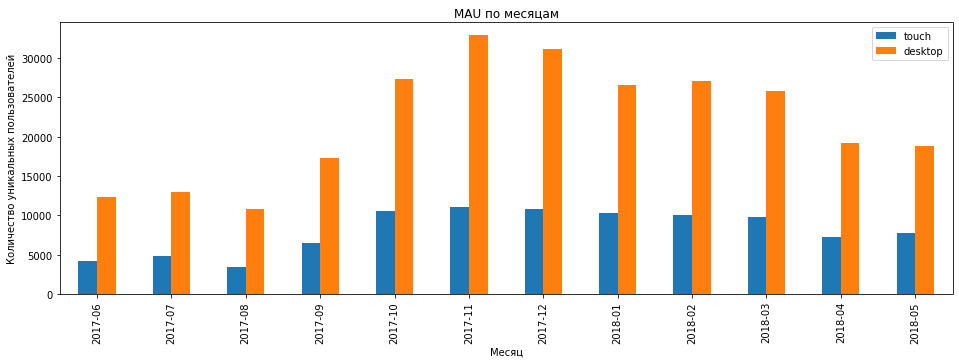

In [12]:
#fix_1
visits_log['month'] = visits_log['start_ts'].dt.to_period('M')
mau_touch = visits_log.query('device == "touch"').groupby(['month'])['uid'].count().to_frame().rename(columns={'uid':'touch'})
mau_desktop = visits_log.query('device == "desktop"').groupby(['month'])['uid'].count().to_frame().rename(columns={'uid':'desktop'})
mau = mau_touch.merge(mau_desktop, on="month")

mau.plot(kind="bar",figsize=(16,5))
plt.title('MAU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных пользователей')
plt.legend()
plt.show()

<a id='step_32'></a>

### 3.2 Сколько сессий в день?

In [13]:
# Функция goal_by_period() получает на вход: 
# датафрейм, отображаемое имя аггрегируемой колонки, массив колонок группировки,
# имя аггрегируемой колонки и функция для аггрегации.
def goal_by_period(df,col_name,group_by,col_id,agg_func):
    df_temp = df.groupby(group_by).agg({col_id: [agg_func,'nunique']})
    df_temp.columns = [col_name, 'users']
    df_temp['per_user'] = df_temp[col_name] / df_temp['users']
    return df_temp

sessions_per_user = goal_by_period(visits_log,'sessions',['device','session_year', 'session_month','session_date'],'uid','count')
sessions_per_user

sessions  users  per_user
device  session_year session_month session_date                           
desktop 2017         6             2017-06-01    501       455    1.101099
                                   2017-06-02    498       458    1.087336
                                   2017-06-03    329       307    1.071661
                                   2017-06-04    349       326    1.070552
                                   2017-06-05    693       631    1.098257
...                                              ...       ...         ...
touch   2018         5             2018-05-27    246       236    1.042373
                                   2018-05-28    321       303    1.059406
                                   2018-05-29    284       263    1.079848
                                   2018-05-30    421       393    1.071247
                                   2018-05-31    712       655    1.087023

[727 rows x 3 columns]

In [14]:
printmd('**Среднее кол-во сессий на уникального пользователя в день**')
print('Всего: {}'.format(sessions_per_user['per_user'].mean()))
print('Desktop: {}'.format(sessions_per_user.query('device == "desktop"')['per_user'].mean()))
print('Touch: {}'.format(sessions_per_user.query('device == "touch"')['per_user'].mean()))

**Среднее кол-во сессий на уникального пользователя в день**

Всего: 1.070042682078994
Desktop: 1.0889551589597752
Touch: 1.0510781047109379


Text(0.5, 1.0, 'Сессий в день')

Text(0.5, 0, 'Месяц')

Text(0, 0.5, 'Количество сессий')

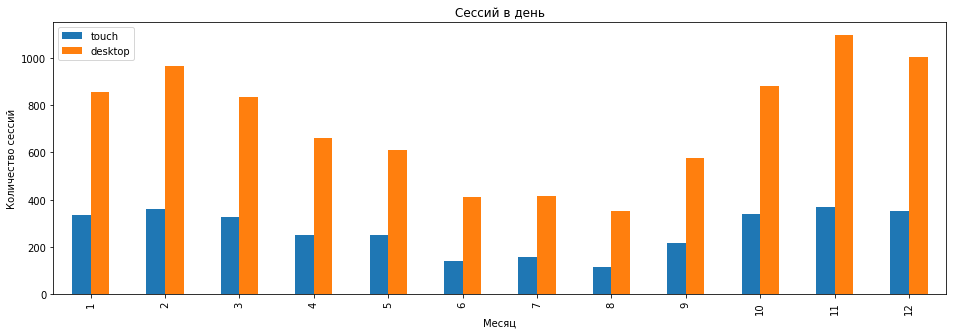

In [15]:
#fix_5.1
sess_length_desktop = sessions_per_user.query('device == "desktop"').groupby(['session_month'])['sessions'].mean().to_frame().rename(columns={'sessions':'desktop'})
sess_length_touch = sessions_per_user.query('device == "touch"').groupby(['session_month'])['sessions'].mean().to_frame().rename(columns={'sessions':'touch'})
sess_length = sess_length_touch.merge(sess_length_desktop, on="session_month")

sess_length.plot(kind="bar",figsize=(16,5))
plt.title('Сессий в день')
plt.xlabel('Месяц')
plt.ylabel('Количество сессий')
plt.legend()
plt.show()

<a id='step_33'></a>
### 3.3 Сколько длится одна сессия? 

Text(0.5, 0, 'Длительность сессии, сек.')

Text(0, 0.5, 'Количество сессий')

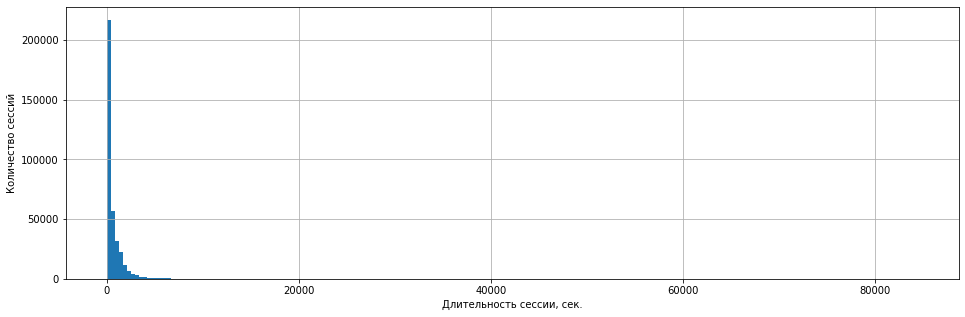

In [16]:
# Чтобы посчитать длину сессии отнял время конца сессии от времени её начала.
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds
plt.xlabel('Длительность сессии, сек.')
plt.ylabel('Количество сессий')
visits_log['session_duration_sec'].hist(bins=200,figsize=(16,5))

count    359358.000000
mean     643.498049   
std      1016.309440  
min      0.000000     
25%      120.000000   
50%      300.000000   
75%      840.000000   
max      84480.000000 
Name: session_duration_sec, dtype: float64

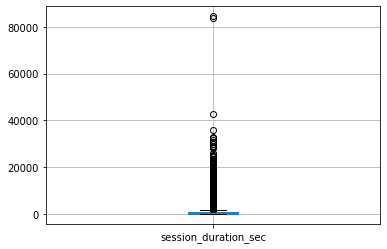

In [17]:
visits_log['session_duration_sec'].describe()
visits_log.boxplot(column='session_duration_sec')

In [18]:
asl = visits_log['session_duration_sec']
print("Мода продолжительности сессии: {} сек".format(int(asl.mode())))

Мода продолжительности сессии: 60 сек


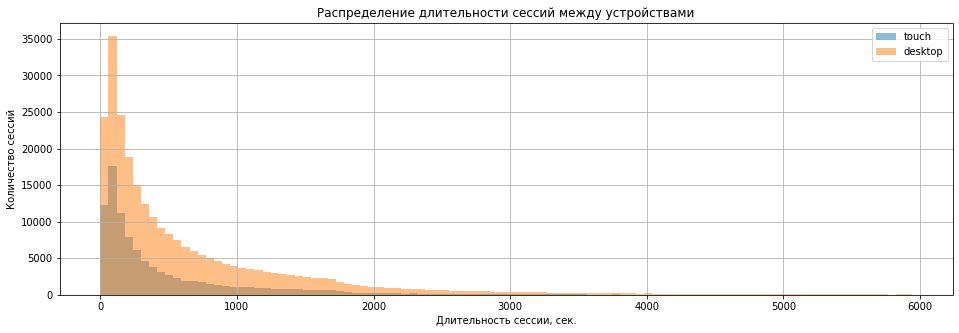

In [19]:
# Отсёк слишком большие значения, чтобы более детально посмотреть на гистограмму.
# Разделил значения на touch и desktop.
def sesstime_compare(df):
    for device in visits_log['device'].unique():
        query = visits_log.query('device == @device and session_duration_sec < 6000')
        query['session_duration_sec'].hist(bins=100, alpha=0.5, figsize=(16,5), label=device)
    plt.title('Распределение длительности сессий между устройствами')
    plt.xlabel('Длительность сессии, сек.')
    plt.ylabel('Количество сессий')
    plt.legend()
    plt.show()
    print()

sesstime_compare(visits_log)

<a id='step_34'></a>
### 3.4 Как часто люди возвращаются?

In [20]:
# Получил дату первой активности из минимального значения колонки `start_ts` с группировкой по `uid`.
first_activity_date = visits_log.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'

# Функция определяющая коэффициент удержания.
def retention(df):
    # Добавил дату первой активности к датафрейму `df`, объединив их по колонке `uid`.
    df = df.join(first_activity_date, on='uid')

    # Поменял типы данных дат для оперирования месяцами.
    df['first_session_month'] = df['first_activity_date'].astype('datetime64[M]')
    df['session_month'] = df['session_date'].astype('datetime64[M]')

    # Вычислил lifetime.
    df['cohort_lifetime'] = df['session_month'] - df['first_session_month']
    df['cohort_lifetime'] = df['cohort_lifetime'] / np.timedelta64(1,'M')
    df['cohort_lifetime'] = df['cohort_lifetime'].round().astype('int')

    # Через lifetime сформировал когорты.
    cohorts = df.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

    # Определил кол-во пользователей по когортам.
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

    # По полю `first_session_month` объеденил датафреймы cohorts и initial_users_count.
    cohorts = cohorts.merge(initial_users_count,on='first_session_month')
    # Вычислил коэффициент удержания
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    
    retention_pivot = cohorts.pivot_table(index='first_session_month',
                                          columns='cohort_lifetime',values='retention',aggfunc='sum')
    return retention_pivot

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Коэффициент удержания по когортам')

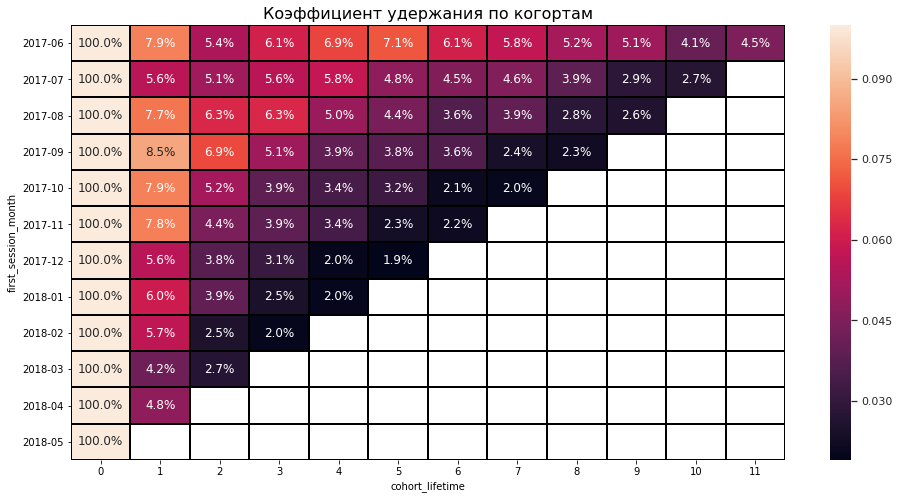

In [21]:
plt.figure(figsize=(16, 8))
plt.title('Коэффициент удержания по когортам',fontsize=16)
sns.set(style="white")
ret_pivot = retention(visits_log)
sns.heatmap(ret_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black', vmax=0.1, yticklabels=ret_pivot.index.strftime('%Y-%m'))

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Коэффициент удержания по когортам для тач-устройств')

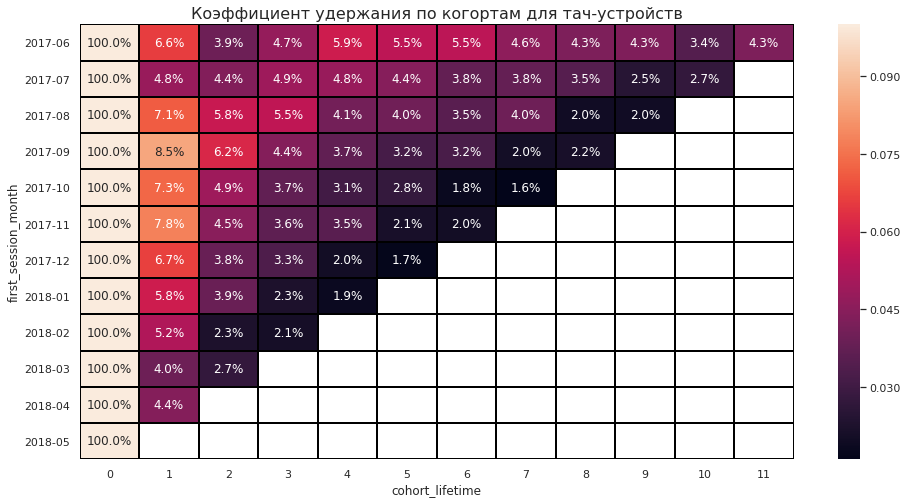

In [22]:
plt.figure(figsize=(16, 8))
plt.title('Коэффициент удержания по когортам для тач-устройств',fontsize=16)
sns.set(style="white")
ret_pivot = retention(visits_log.query('device == "touch"'))
sns.heatmap(ret_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black', vmax=0.1, yticklabels=ret_pivot.index.strftime('%Y-%m'))

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Коэффициент удержания по когортам для десктоп-устройств')

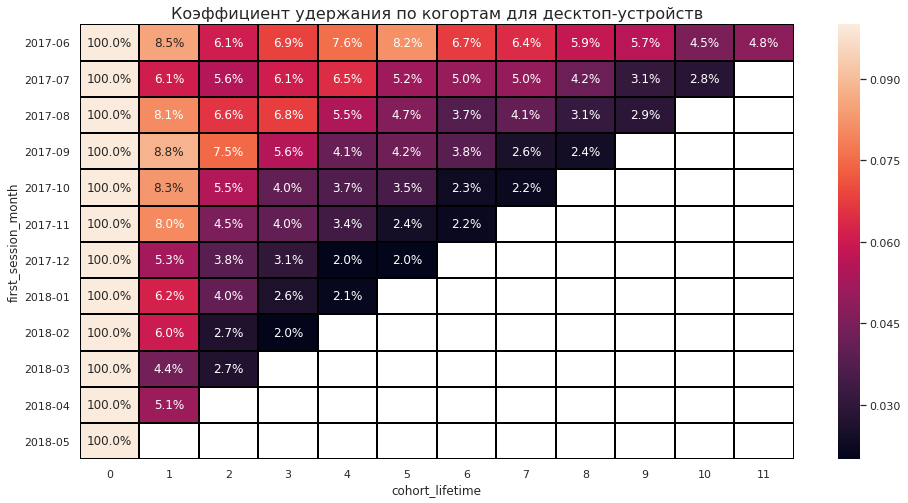

In [23]:
plt.figure(figsize=(16, 8))
plt.title('Коэффициент удержания по когортам для десктоп-устройств',fontsize=16)
sns.set(style="white")
ret_pivot = retention(visits_log.query('device == "desktop"'))
sns.heatmap(ret_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='black', vmax=0.1, yticklabels=ret_pivot.index.strftime('%Y-%m'))

### Вывод

По статистике за период с июня 2017 по конец мая 2018 года:
- Уникальных desktop-пользователей в 2.5 раза больше, чем touch-пользователей.
- Каждый пользователь в среднем заходит 1 раз в день.
- Средняя продолжительность сессии у большинства пользователей 60 секунд.
- Наивысшый показатель Retention Rate был в сентябре 2017 года как для десктоп, так и для тач-устройств. В октябре 2017 для некоторых когорт у десктопа рост продолжился. Что нельзя сказать о тач-устройствах, у старых когорт тача виден постепенный упадок после сентября 2017 года.

<a id='step_4'></a>
## 4. Продажи:

<a id='step_41'></a>
### 4.1 Когда люди начинают покупать?

In [24]:
# Записал время первой покупки в таблицу first_buy_date.
first_buy_date = orders_log.groupby('uid')['buy_ts'].min()
first_buy_date = first_buy_date.to_frame()

# По столбцу `uid` объеденил таблицы времени регистрации и времени первой покупки.
order_time = first_activity_date.to_frame()
devices = visits_log.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'device': 'first'})

order_time = order_time.merge(first_buy_date,on='uid')
order_time = order_time.merge(devices,on='uid')

# Сократил время колонок до дней. 
order_time['first_activity_date'] = order_time['first_activity_date'].astype('datetime64[D]')
order_time['buy_ts'] = order_time['buy_ts'].astype('datetime64[D]')

# В столбце `first_buy_duration` посчитал сколько дней проходит с момента регистрации до момента первой покупки.
order_time['days_till_first_buy'] = order_time['buy_ts'] - order_time['first_activity_date']
order_time['days_till_first_buy'] = order_time['days_till_first_buy'] / np.timedelta64(1, 'D')
order_time.head(5)

,first_activity_date,buy_ts,device,days_till_first_buy
uid,,,,
313578113262317,2017-09-18,2018-01-03,desktop,107.0
1575281904278712,2017-06-03,2017-06-03,touch,0.0
2429014661409475,2017-10-11,2017-10-11,desktop,0.0
2464366381792757,2018-01-27,2018-01-28,desktop,1.0
2551852515556206,2017-11-24,2017-11-24,desktop,0.0


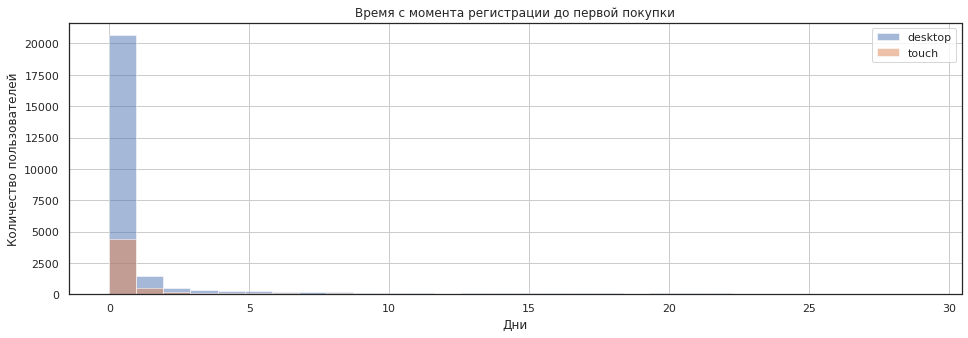

In [25]:
def firstbuy_compare(df):
    for device in order_time['device'].unique():
        # Отсёк слишком большие значения, чтобы более детально посмотреть на гистограмму.
        query = order_time.query('device == @device and days_till_first_buy < 30')
        query['days_till_first_buy'].hist(bins=30, alpha=0.5, figsize=(16,5), label=device)
    plt.title('Время с момента регистрации до первой покупки')
    plt.xlabel('Дни')
    plt.ylabel('Количество пользователей')
    plt.legend()
    plt.show()
    print()

firstbuy_compare(order_time)

**В целом**

count    36522.000000
mean     16.896364   
std      47.071762   
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      2.000000    
max      363.000000  
Name: days_till_first_buy, dtype: float64

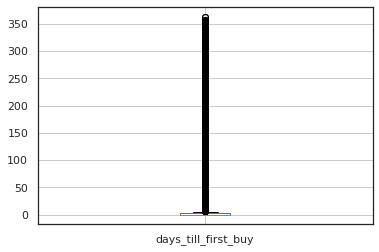

In [26]:
printmd('**В целом**')
order_time['days_till_first_buy'].describe()
order_time.boxplot(column='days_till_first_buy')

**Touch**

count    7312.000000
mean     20.456100  
std      50.381977  
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      7.000000   
max      363.000000 
Name: days_till_first_buy, dtype: float64

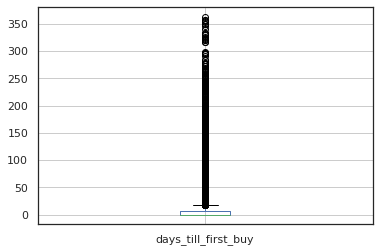

In [27]:
printmd('**Touch**')
order_time.query('device == "touch"')['days_till_first_buy'].describe()
order_time.query('device == "touch"').boxplot(column='days_till_first_buy')

**Desktop**

count    29210.000000
mean     16.005272   
std      46.164007   
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      1.000000    
max      363.000000  
Name: days_till_first_buy, dtype: float64

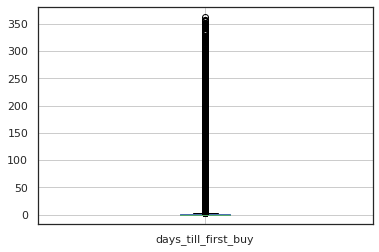

In [28]:
printmd('**Desktop**')
order_time.query('device == "desktop"')['days_till_first_buy'].describe()
order_time.query('device == "desktop"').boxplot(column='days_till_first_buy')

In [29]:
percent_first_day = order_time.query('days_till_first_buy == 0')['days_till_first_buy'].count() / order_time['days_till_first_buy'].count() * 100
perce_first_month = order_time.query('days_till_first_buy > 0 and days_till_first_buy < 31')['days_till_first_buy'].count() / order_time['days_till_first_buy'].count() * 100

print("Мода дней с регистрации до первой покупки: {} дней".format(int(order_time['days_till_first_buy'].mode())))
print("Процент пользователей покупающих впервые в день регистрации: {:.2f}%".format(percent_first_day))
print("Процент пользователей покупающих впервые в промежуток от 1 до 30 дней с момента регистрации: {:.2f}%".format(perce_first_month))

Мода дней с регистрации до первой покупки: 0 дней
Процент пользователей покупающих впервые в день регистрации: 68.56%
Процент пользователей покупающих впервые в промежуток от 1 до 30 дней с момента регистрации: 17.93%


<a id='step_42'></a>
### 4.2 Сколько раз покупают за период?

In [30]:
# Добавил колонки с годами, месяцами, неделями и датами покупок.
orders_log['buy_year']  = orders_log['buy_ts'].dt.year
orders_log['buy_month'] = orders_log['buy_ts'].dt.month
orders_log['buy_week']  = orders_log['buy_ts'].dt.week
orders_log['buy_date'] = orders_log['buy_ts'].dt.date

# Добавил девайсы к покупкам.
orders_log = orders_log.merge(devices,on='uid')

orders_log.head(5)

,uid,buy_ts,revenue,buy_year,buy_month,buy_week,buy_date,device
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017,6,22,2017-06-01,desktop
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017,6,22,2017-06-01,desktop
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017,6,22,2017-06-01,desktop
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017,6,22,2017-06-01,desktop
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017,6,22,2017-06-01,desktop


In [31]:
orders_by_month = goal_by_period(orders_log,'buys',['device','buy_year','buy_month'],'uid','count')
orders_by_month

buys  users  per_user
device  buy_year buy_month                       
desktop 2017     6          1994  1702   1.171563
                 7          1889  1577   1.197844
                 8          1493  1199   1.245204
                 9          2761  2208   1.250453
                 10         4624  3815   1.212058
                 11         4602  3705   1.242105
                 12         5033  3968   1.268397
        2018     1          3823  3108   1.230051
                 2          4185  3314   1.262824
                 3          4265  3324   1.283093
                 4          2713  2242   1.210080
                 5          3543  2816   1.258168
                 6          1     1      1.000000
touch   2017     6          360   321    1.121495
                 7          474   407    1.164619
                 8          313   272    1.150735
                 9          626   542    1.154982
                 10         1055  860    1.226744
                 11         1057  842    1.255344
                 12         1185  974    1.216632
        2018     1          898   790    1.136709
                 2          1096  944    1.161017
                 3          1061  857    1.238040
                 4          560   502    1.115538
                 5          803   728    1.103022

In [32]:
printmd('**Количество покупок:**')
orders_by_month['per_user'].describe()

**Количество покупок:**

count    25.000000
mean     1.195069 
std      0.066478 
min      1.000000 
25%      1.154982 
50%      1.212058 
75%      1.245204 
max      1.283093 
Name: per_user, dtype: float64

<a id='step_43'></a>
### 4.3 Какой средний чек?

In [33]:
aov = goal_by_period(orders_log,'revenue',['device','buy_year','buy_month'],'revenue','sum')
aov

revenue  users   per_user
device  buy_year buy_month                            
desktop 2017     6          8321.37   186    44.738548
                 7          10251.79  175    58.581657
                 8          7257.37   185    39.229027
                 9          15631.37  276    56.635399
                 10         23094.75  356    64.872893
                 11         21693.31  444    48.858806
                 12         32105.87  477    67.307904
        2018     1          16344.38  353    46.301360
                 2          21632.63  377    57.380981
                 3          23295.06  436    53.429037
                 4          14044.53  269    52.210149
                 5          17652.70  294    60.043197
                 6          3.42      1      3.420000 
touch   2017     6          1236.12   86     14.373488
                 7          2287.68   85     26.913882
                 8          1500.19   86     17.444070
                 9          2714.14   123    22.066179
                 10         4892.95   173    28.282948
                 11         5376.62   227    23.685551
                 12         4282.73   194    22.075928
        2018     1          3072.75   146    21.046233
                 2          3927.91   179    21.943631
                 3          5539.53   221    25.065747
                 4          2813.53   126    22.329603
                 5          3083.28   124    24.865161

In [34]:
#fix_2
printmd('**Средний чек:**')
orders_log['revenue'].describe()['mean']
printmd('**Средний чек, desktop:**')
orders_log.query('device == "desktop"')['revenue'].describe()['mean']
printmd('**Средний чек, touch:**')
orders_log.query('device == "touch"')['revenue'].describe()['mean']

**Средний чек:**

4.99972190264609

**Средний чек, desktop:**

5.163674681131798

**Средний чек, touch:**

4.29252002529511

Text(0.5, 1.0, 'Средний чек по источникам')

Text(0.5, 0, 'Месяц')

Text(0, 0.5, 'Цена')

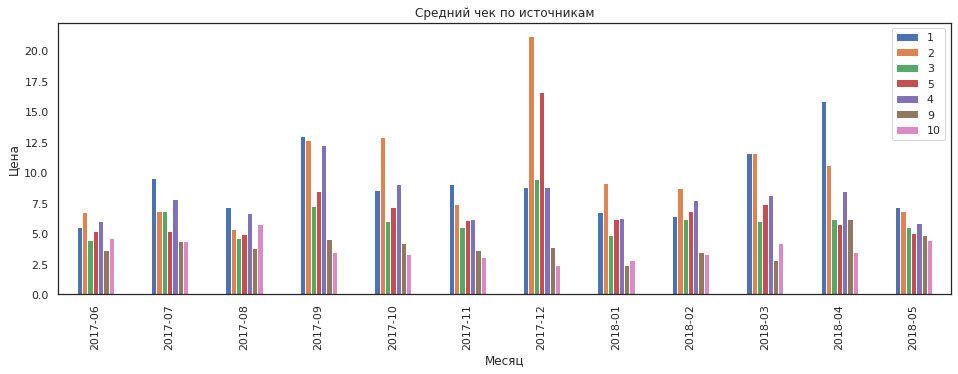

In [35]:
#fix_5.2
orders = orders_log.merge(visits_log[['uid','source_id']],on='uid')
orders['month'] = orders['buy_ts'].dt.to_period('M')
aov_by_source = orders.groupby(['month'])['revenue'].mean().to_frame().rename(columns={'revenue':'total'})
for item in orders['source_id'].unique():
    temp = orders.query('source_id == @item').groupby(['month'])['revenue'].mean().to_frame().rename(columns={'revenue':item})
    aov_by_source = aov_by_source.merge(temp, on="month")

aov_by_source = aov_by_source.drop(aov_by_source.columns[[0]],axis=1)

aov_by_source.plot(kind="bar",figsize=(16,5))
plt.title('Средний чек по источникам')
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.legend()
plt.show()

<a id='step_44'></a>
### 4.4 Сколько денег приносят? (LTV)

In [36]:
# Определил источник пользователя
sources = visits_log.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

# Соединил первые покупки и источники 
buyers = orders_log.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
buyers = buyers.rename(columns = {'buy_ts': 'first_buy'})


#Соединил buyers и orders_log 
merged = buyers.merge(orders_log, on = 'uid')

#Нашел возраст когорты
merged['lifetime'] = ((merged['buy_ts'] - merged['first_buy']) / np.timedelta64(1,'M')).round().astype(int)

#Создал сводную таблицу ltv_cohorts где за индекс принимается `source_id`, 
#а значениями является прибыль с разбивкой по возрасту когорты. 
#Сумма по источнику накапливается куммулитивно возрасту когорт.
ltv_cohorts = merged.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0).cumsum(axis = 1)

# Добавил размеры когорт
# div(ltv['cohort_size'], axis = 0) берет столбец cohort_size и делит на него каждый столбец фрейма
cohort_sizes = buyers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv_cohorts = ltv_cohorts.merge(cohort_sizes, on = 'source_id')
ltv_cohorts = ltv_cohorts.div(ltv_cohorts['cohort_size'], axis = 0).drop(columns = 'cohort_size')

ltv_cohorts

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,7.150835,7.891156,8.537754,9.029303,9.251083,9.525826,9.866858,10.191256,10.450862,10.557561,10.673508,10.724577
2,6.770593,8.054740,9.717921,11.253637,11.900125,12.484390,12.721418,12.948380,13.171358,13.233560,13.346994,13.380422,13.383802
3,4.477694,4.729283,4.865748,5.008149,5.083093,5.122590,5.147003,5.173669,5.192354,5.197477,5.202699,5.203834,5.204931
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.164131,3.227434,3.254695,3.302558,3.316576,3.319217,3.332724,3.343348,3.346102,3.348631,3.348631,3.348631,3.348631


In [37]:
#Тоже самое проделал для разных девайсов.
ltv_devices = merged.pivot_table(index = 'device', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv_devices = ltv_devices.cumsum(axis = 1)

buyers = buyers.merge(devices, on = 'uid').reset_index()

device_sizes = buyers.groupby('device').agg({'uid': 'nunique'}).rename(columns = {'uid': 'device_size'})
ltv_devices = ltv_devices.merge(device_sizes, on = 'device')
ltv_devices = ltv_devices.div(ltv_devices['device_size'], axis = 0).drop(columns = 'device_size')

ltv_devices

,0,1,2,3,4,5,6,7,8,9,10,11,12
device,,,,,,,,,,,,,
desktop,4.910270,5.300013,5.710743,6.364138,6.606553,6.782581,6.915700,7.018920,7.107216,7.167960,7.212136,7.229669,7.234801
touch,4.747406,5.024646,5.209044,5.275748,5.330682,5.461850,5.484181,5.519675,5.531470,5.546719,5.558411,5.564929,5.569944


<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'LTV, девайсы с разбивкой по когортам')

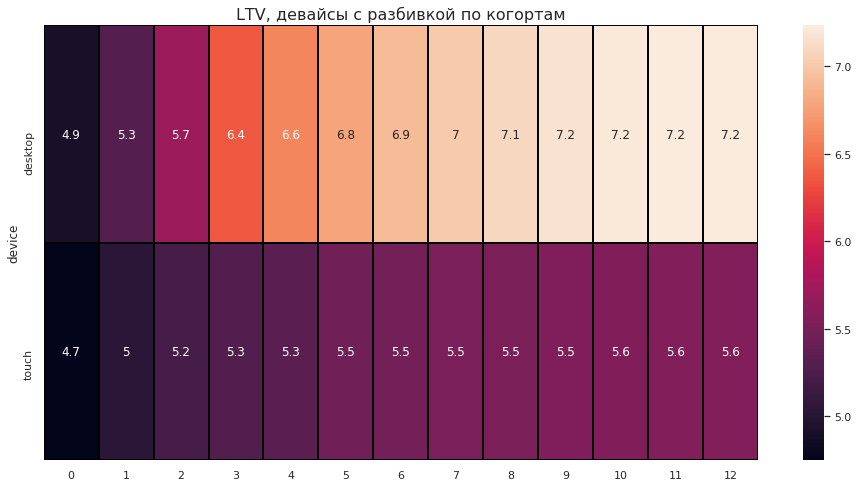

In [38]:
plt.figure(figsize=(16, 8))
plt.title('LTV, девайсы с разбивкой по когортам',fontsize=16)
sns.set(style="white")
sns.heatmap(ltv_devices, annot=True, linewidths=1, linecolor='black')

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'LTV, рекламные источники с разбивкой по когортам')

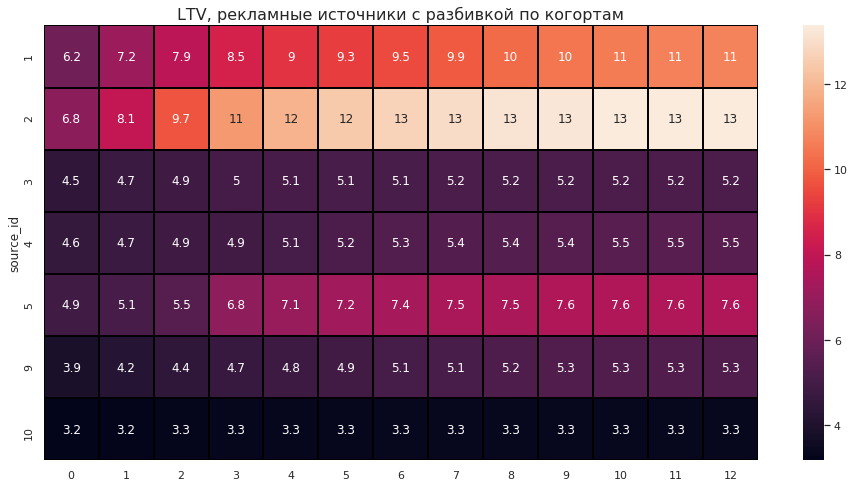

In [39]:
plt.figure(figsize=(16, 8))
plt.title('LTV, рекламные источники с разбивкой по когортам',fontsize=16)
sns.set(style="white")
sns.heatmap(ltv_cohorts, annot=True, linewidths=1, linecolor='black')

### Вывод

1. Большинство пользоваталей (68.56%) совершают покупку в день регистрации, а еще 17.93% в течении первого месяца.
2. В месяц на каждых 5 пользователей приходится 6 покупок.
3. Средний чек в месяц у десктоп пользователей 50.23 у.е., а тач пользователей 22.5 у.е.
4. Самый большой показатель LTV у рекламного источника №2, немного отстает 1 источник. Средние показатели LTV у 5-го источника и ниже среднего у 3, 4, 9 источников. Самую низкий показатель показывает 10 источник.
5. LTV у desktop больше, чем у touch, 7.2 против 5.6.

<a id='step_5'></a>
## 5. Маркетинг:

<a id='step_51'></a>
### 5.1 Сколько денег потратили?

In [40]:
#Всего
print('Всего потрачено на маркетинг: {}'.format(costs['costs'].sum()))

Всего потрачено на маркетинг: 329131.62


In [41]:
#На каждый источник 
source_costs = costs.groupby('source_id')['costs'].sum().to_frame()
source_costs['percent'] = source_costs['costs'] / source_costs['costs'].sum() * 100
source_costs.sort_values(by="costs",ascending=False)

,costs,percent
source_id,,
3,141321.63,42.937725
4,61073.60,18.555981
5,51757.10,15.725350
2,42806.04,13.005751
1,20833.27,6.329769
10,5822.49,1.769046
9,5517.49,1.676378


source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Потрачено денег')

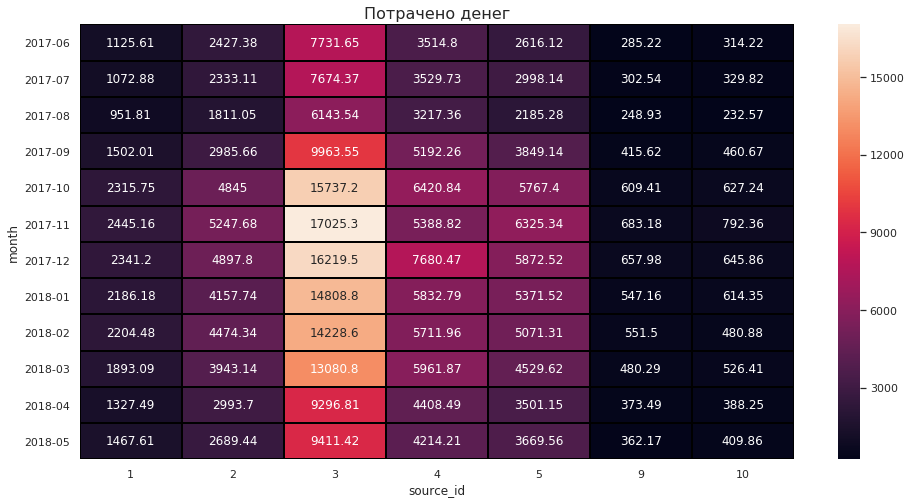

In [42]:
#По времени
costs['month'] = costs['dt'].dt.to_period('M')

costs_by_month = costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'sum').fillna(0)
costs_by_month

plt.figure(figsize=(16, 8))
plt.title('Потрачено денег',fontsize=16)
sns.set(style="white")
sns.heatmap(costs_by_month, annot=True, linewidths=1, fmt='g', linecolor='black')

<a id='step_52'></a>
### 5.2 Сколько стоило привлечение одного покупателя из каждого источника?

In [43]:
# считаем САС
cac = costs.groupby('source_id').agg({'costs': 'sum'}).merge(cohort_sizes, on = 'source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac.sort_values(by='cac',ascending=True)

,costs,cohort_size,cac
source_id,,,
10,5822.49,1329,4.381106
9,5517.49,1088,5.071222
4,61073.60,10296,5.931779
1,20833.27,2899,7.186364
5,51757.10,6931,7.467479
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901


Text(0.5, 1.0, 'Стоимость привлечения одного покупателя для каждого источника')

Text(0.5, 0, 'Стоимость')

Text(0, 0.5, 'Источники')

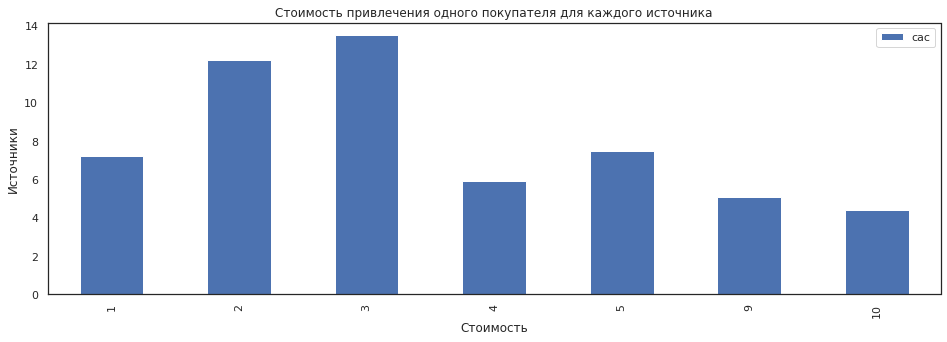

In [44]:
#fix_3
cac['cac'].plot(kind="bar",figsize=(16,5))
plt.title('Стоимость привлечения одного покупателя для каждого источника')
plt.xlabel('Стоимость')
plt.ylabel('Источники')
plt.legend()
plt.show()

costs  cohort_size        cac
month   source_id                                 
2018-03 10         526.41   186          2.830161 
        9          480.29   161          2.983168 
2017-10 10         627.24   209          3.001148 
2018-05 10         409.86   130          3.152769 
2017-06 10         314.22   95           3.307579 
...                   ...   ...               ... 
2017-08 2          1811.05  123          14.723984
2017-07 3          7674.37  512          14.989004
2018-04 3          9296.81  619          15.019079
2018-02 2          4474.34  293          15.270785
2017-08 3          6143.54  337          18.230089

[84 rows x 3 columns]

Text(0.5, 1.0, 'CAC по рекламным источникам')

Text(0.5, 0, 'Месяц')

Text(0, 0.5, 'Стоимость привлечения')

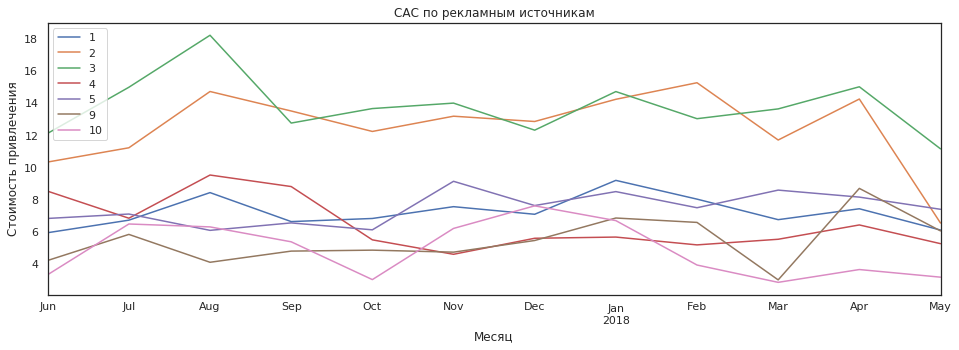

In [45]:
#fix_6
buyers['month'] = buyers['first_buy'].dt.to_period('M')
cohort_sizes = buyers.groupby(['month','source_id']).agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'}) #fix_6.1

cac_by_month = costs.groupby(['month','source_id']).agg({'costs': 'sum'}).merge(cohort_sizes, on=['month','source_id'])
cac_by_month['cac'] = cac_by_month['costs'] / cac_by_month['cohort_size']
cac_by_month.sort_values(by='cac',ascending=True)


cac_by_source = cac_by_month.pivot_table(index = 'month', columns = 'source_id', values = 'cac', aggfunc = 'sum').fillna(0)
cac_by_source.plot(kind="line",figsize=(16,5))
plt.title('CAC по рекламным источникам')
plt.xlabel('Месяц')
plt.ylabel('Стоимость привлечения')
plt.legend()
plt.show()

<a id='step_53'></a>
### 5.3 На сколько окупились расходы? (ROI)

In [46]:
# считаем ROI
roi = ltv_cohorts.merge(cac[['cac']], on = 'source_id')
roi = roi.div(roi['cac'], axis = 0).drop(columns = 'cac')

#fix_4
roi = roi.drop(roi.columns[[12]],axis=1)

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, '')

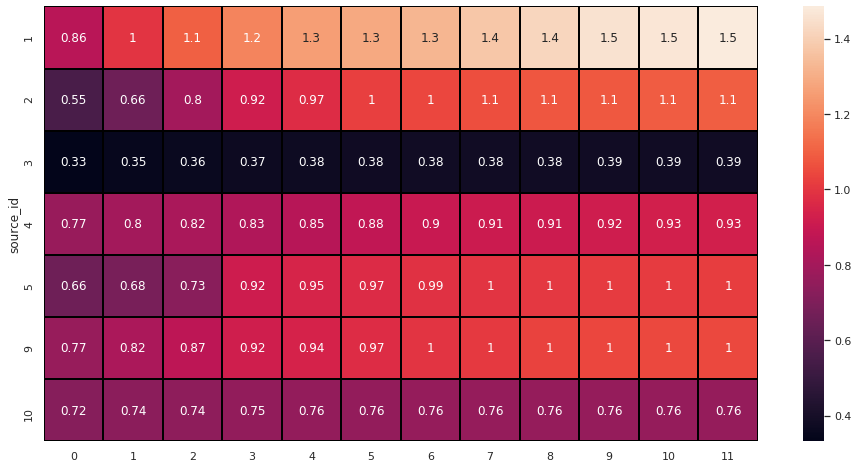

In [47]:
plt.figure(figsize=(16, 8))
plt.title('',fontsize=16)
sns.set(style="white")
sns.heatmap(roi, annot=True, linewidths=1, linecolor='black')

### Вывод

1. Всего было потрачено 329131.62 у.е.
2. Самым затратным является 3 источник, к тому же он не окупился, ROI 0.33-0.39.
3. Самым прибыльным является источник №1, который окупился на второй месяц.
4. Источники 2, 5, 9 окупились на пятый, седьмой, шестой месяца.
5. Источники 4 и 10 за время исследуемого периода не окупились.

<a id='step_6'></a>
## 6. Общий вывод:

На основе данных от июня 2017 до конца мая 2018 года были проведены исследования и выявлены показатели метрик: Retantion Rate, DAU, MAU, WAU, LTV, AOV, CAC, ROI.<br>

По результату подготовил рекомендации для увеличения прибыли:
1. Убрать 10-ый рекламный источник из маркетинговой кампании, поскольку показатель LTV и ROI слишком низок.
2. Увеличить долю рекламных вложений 1 источника до 30% от всего бюджета.
3. Доли 2, 5, 9 источников довести до 20% от общего бюджета.
4. Доли 3 и 4 довести до 5%.

При формировании бюджета упор стоит делать на desktop-устройства. Соотношение desktop к touch рекомендуется 2 к 1.